In [118]:
import fastfusion
import fastfusion as ff
from fastfusion.frontend.workload._isl import get_tensor_size
from fastfusion.util import set_n_parallel_jobs
from fastfusion.mapper import Metrics
import time

set_n_parallel_jobs(12)

from fastfusion.mapper.FFM._join_pmappings.sim import SIM

# Set "MainMemory" to whatever the off-chip memory is
def no_hybrid_mapping__filter(pm: SIM):
    fused_tensors = [x for x in pm.compatibility.tensors if x.resource_name != "MainMemory"]
    # Same # of fused loops above all fused tensors
    return len(set(len(x.loops) for x in fused_tensors)) <= 1

def no_fused__filter(pm: SIM):
    return all(reservation.resource_name == "MainMemory" for reservation in pm.compatibility.tensors)

import csv
import pickle

from IPython.display import display, SVG

from paths import ARCH_DIR, WORKLOADS_DIR

In [ ]:
def make_spec(arch_fname, workload_fname):
    spec = fastfusion.Specification.from_yaml(
        ARCH_DIR / arch_fname,
        WORKLOADS_DIR / workload_fname,
    )
    spec.mapper.ffm.metrics = Metrics.LATENCY | Metrics.ENERGY
    # spec.mapper.ffm.max_fused_loops = 3
    spec.mapper.ffm.max_fused_loops_per_rank_variable = 1
    return spec

def run_make_pmappings(spec):
    start = time.time()
    pmappings = fastfusion.mapper.FFM.make_pmappings(spec)
    end = time.time()
    duration = end - start
    return pmappings, duration

def run_join_pmappings(spec, pmappings):
    start = time.time()
    mappings = fastfusion.mapper.FFM.join_pmappings(spec, pmappings)
    end = time.time()
    duration = end - start
    return mappings, duration

def run_experiments(shape):
    spec = make_spec("nvdla.arch.yaml", f"mobilenet_{shape}.yaml")

    # LoopForest
    pmappings = ff.mapper.FFM.make_pmappings(spec)
    loopforest_mappings = ff.mapper.FFM.join_pmappings(spec, pmappings)

    # LoopTree
    lt_pmappings = pmappings._filter(no_hybrid_mapping_filter)
    looptree_mappings = ff.mapper.FFM.join_pmappings(spec, lt_pmappings)

    # Unfused
    un_pmappings = pmappings._filter(no_fused_filter)
    unfused_mappings = ff.mapper.FFM.join_pmappings(spec, un_pmappings)

    # TileFlow
    spec.mapper.ffm._timeloop_style_even = True
    pmappings = ff.mapper.FFM.make_pmappings(spec)
    pmappings = pmappings._filter(no_hybrid_mapping_filter)
    tileflow_mappings = ff.mapper.FFM.join_pmappings(spec, pmappings)

    return loopforest_mappings, looptree_mappings, tileflow_mappings, unfused_mappings

In [3]:
def compute_latency(all_mappings, names, baseline, fname):
    for name, mappings in zip(names, all_mappings):
        if name != baseline:
            continue
        baseline_latency = mappings.data["Total<SEP>latency"].iloc[0]
        baseline_energy = mappings.data["Total<SEP>energy"].iloc[0]
        ideal_latency = mappings.data[[c for c in mappings.data.columns if "latency" in c and "compute" in c]].iloc[0].sum()

    message = ''
    for name, mappings in zip(names, all_mappings):
        message += name + '\n'
        latency = mappings.data["Total<SEP>latency"].iloc[0]
        energy = mappings.data["Total<SEP>energy"].iloc[0]
        message += f"{latency/baseline_latency} ({latency/ideal_latency}); {energy/baseline_energy}\n"
    
    with open(fname, "w") as f:
        f.write(message)

In [4]:
for shape in [7]:
    lf, lt, tf, un = run_experiments(shape)
    with open(f"lf_{shape}.pkl", "wb") as f:
        pickle.dump(lf, f)
    with open(f"lt_{shape}.pkl", "wb") as f:
        pickle.dump(lt, f)
    with open(f"tf_{shape}.pkl", "wb") as f:
        pickle.dump(tf, f)
    with open(f"un_{shape}.pkl", "wb") as f:
        pickle.dump(un, f)

WARNING Loading configuration file from /home/gilbertm/work/venv/fastfusion/config.yaml
Generating pmapping templates for compute MAC Einsum PwiseA0: 8it [00:00, 43.09it/s]]
Generating pmapping templates for compute MAC Einsum PwiseB2: 8it [00:00, 43.40it/s]]
Generating pmapping templates for compute MAC Einsum PwiseB0: 16it [00:00, 65.73it/s]
Generating pmapping templates for compute MAC Einsum PwiseA1: 16it [00:00, 65.66it/s]
Generating pmapping templates for compute MAC Einsum Dwise1: 84it [00:00, 146.69it/s]
Generating pmapping templates for compute MAC Einsum Dwise0: 84it [00:00, 149.77it/s]
Generating jobs: 100%|██████████| 6/6 [00:04<00:00,  1.34it/s]
WARNING Einsum PwiseA0 has 8 pmapping templates:
WARNING 	[WA0,T0 in MainMemory] T-p0,q0,t0  [T0 in GlobalBuffer] T-t0  [TA0 in GlobalBuffer] T-n0,t0  [WA0 in GlobalBuffer] T-p0,q0  S-Y-n0  S-X-t0  MAC computes PwiseA0
WARNING 	[WA0,T0 in MainMemory] T-p0,q0,t0  [T0 in GlobalBuffer] T-t0  [TA0 in GlobalBuffer] T-n0,t0  [WA0 in Glob

Dwise0: 1.34e06 total, 4.97e05 (1/3) valid, 1.04e06 (1/1) evaluated, 2.20e04 (1/61) Pareto-Optimal
PwiseA0: 3.48e05 total, 1.07e05 (1/3) valid, 2.77e04 (1/13) evaluated, 940 (1/370) Pareto-Optimal
PwiseB0: 4.82e05 total, 2.45e05 (1/2) valid, 4.57e04 (1/11) evaluated, 1.61e03 (1/300) Pareto-Optimal
PwiseA1: 5.67e05 total, 2.25e05 (1/3) valid, 4.25e04 (1/13) evaluated, 1.55e03 (1/366) Pareto-Optimal
Dwise1: 7.53e05 total, 2.81e05 (1/3) valid, 7.49e05 (1/1) evaluated, 1.13e04 (1/67) Pareto-Optimal
PwiseB2: 3.03e05 total, 1.04e05 (1/3) valid, 2.94e04 (1/10) evaluated, 1.01e03 (1/299) Pareto-Optimal
Total: 3.79e06 total, 1.46e06 (1/3) valid, 1.94e06 (1/2) evaluated, 3.84e04 (1/99) Pareto-Optimal
Einsum PwiseA0 has 940 pmappings with 16 compatibilities
Einsum Dwise0 has 21953 pmappings with 74 compatibilities
Einsum PwiseB0 has 1610 pmappings with 63 compatibilities
Einsum PwiseA1 has 1548 pmappings with 63 compatibilities
Einsum Dwise1 has 11303 pmappings with 54 compatibilities
Einsum Pwis

Compressing pmappings: 100%|██████████| 6/6 [00:00<00:00, 32.47it/s]


Not tracking MainMemory because it is never reserved for multiple pmappings.
Not tracking Register because it is never reserved for multiple pmappings.


Merging pmappings for Dwise1 <--> PwiseB2 (6/6): 100%|██████████| 38/38 [00:01<00:00, 20.01it/s]
/home/gilbertm/work/active/fastfusion/fastfusion/mapper/FFM/_interface/main.py:162: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  joined._data = joined.data.fillna(0).reset_index(drop=True)


Einsum PwiseA0 has 940 pmappings with 16 compatibilities
Einsum Dwise0 has 12668 pmappings with 47 compatibilities
Einsum PwiseB0 has 1258 pmappings with 35 compatibilities
Einsum PwiseA1 has 1196 pmappings with 35 compatibilities
Einsum Dwise1 has 7241 pmappings with 27 compatibilities
Einsum PwiseB2 has 1012 pmappings with 16 compatibilities


Compressing pmappings: 100%|██████████| 6/6 [00:00<00:00, 57.11it/s]


Not tracking MainMemory because it is never reserved for multiple pmappings.
Not tracking Register because it is never reserved for multiple pmappings.


Merging pmappings for Dwise1 <--> PwiseB2 (6/6): 100%|██████████| 31/31 [00:00<00:00, 507.40it/s]
/home/gilbertm/work/active/fastfusion/fastfusion/mapper/FFM/_interface/main.py:162: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  joined._data = joined.data.fillna(0).reset_index(drop=True)


Einsum PwiseA0 has 1 pmappings with 1 compatibilities
Einsum Dwise0 has 1 pmappings with 1 compatibilities
Einsum PwiseB0 has 1 pmappings with 1 compatibilities
Einsum PwiseA1 has 1 pmappings with 1 compatibilities
Einsum Dwise1 has 1 pmappings with 1 compatibilities
Einsum PwiseB2 has 1 pmappings with 1 compatibilities


Compressing pmappings: 100%|██████████| 6/6 [00:00<00:00, 545.13it/s]


Not tracking GlobalBuffer because it is never reserved for multiple pmappings.
Not tracking MainMemory because it is never reserved for multiple pmappings.
Not tracking Register because it is never reserved for multiple pmappings.


Final consolidate: 100%|██████████| 1/1 [00:00<00:00, 21620.12it/s]
Generating pmapping templates for compute MAC Einsum PwiseA0: 8it [00:00, 68.65it/s]]
Generating pmapping templates for compute MAC Einsum PwiseB2: 8it [00:00, 63.44it/s]
Generating pmapping templates for compute MAC Einsum PwiseB0: 16it [00:00, 50.42it/s]
Generating pmapping templates for compute MAC Einsum PwiseA1: 16it [00:00, 50.24it/s]
Generating pmapping templates for compute MAC Einsum Dwise0: 84it [00:01, 76.44it/s] 
Generating pmapping templates for compute MAC Einsum Dwise1: 84it [00:01, 75.20it/s]
Generating jobs: 100%|██████████| 6/6 [00:02<00:00,  2.83it/s]
WARNING Einsum PwiseA0 has 8 pmapping templates:
WARNING 	[WA0,T0 in MainMemory] T-p0,q0,t0  [T0 in GlobalBuffer] T-t0  [TA0,WA0 in GlobalBuffer] T-n0,p0,q0,t0  S-Y-n0  S-X-t0  MAC computes PwiseA0
WARNING 	[WA0,T0 in MainMemory] T-p0,q0,t0  [T0 in GlobalBuffer] T-t0  [TA0,WA0 in GlobalBuffer] T-n0,t0  S-Y-n0  S-X-t0  [WA0 in Register] T-p0,q0  MAC comp

Dwise0: 1.48e06 total, 6.36e05 (1/2) valid, 6.99e05 (1/2) evaluated, 7.53e03 (1/197) Pareto-Optimal
Dwise1: 8.73e05 total, 3.91e05 (1/2) valid, 4.68e05 (1/2) evaluated, 4.54e03 (1/192) Pareto-Optimal
PwiseA0: 4.76e05 total, 2.03e05 (1/2) valid, 1.86e04 (1/26) evaluated, 939 (1/507) Pareto-Optimal
PwiseB0: 5.86e05 total, 2.90e05 (1/2) valid, 3.01e04 (1/19) evaluated, 1.58e03 (1/371) Pareto-Optimal
PwiseA1: 6.87e05 total, 2.77e05 (1/2) valid, 2.73e04 (1/25) evaluated, 1.52e03 (1/453) Pareto-Optimal
PwiseB2: 4.53e05 total, 1.91e05 (1/2) valid, 2.01e04 (1/23) evaluated, 1.00e03 (1/451) Pareto-Optimal
Total: 4.56e06 total, 1.99e06 (1/2) valid, 1.26e06 (1/4) evaluated, 1.71e04 (1/267) Pareto-Optimal
Einsum PwiseA0 has 939 pmappings with 16 compatibilities
Einsum Dwise0 has 5590 pmappings with 32 compatibilities
Einsum PwiseB0 has 1270 pmappings with 31 compatibilities
Einsum PwiseA1 has 1204 pmappings with 31 compatibilities
Einsum Dwise1 has 3585 pmappings with 18 compatibilities
Einsum Pwi

Compressing pmappings: 100%|██████████| 6/6 [00:00<00:00, 83.76it/s]


Not tracking MainMemory because it is never reserved for multiple pmappings.
Not tracking Register because it is never reserved for multiple pmappings.


Merging pmappings for Dwise1 <--> PwiseB2 (6/6): 100%|██████████| 31/31 [00:00<00:00, 506.17it/s]
/home/gilbertm/work/active/fastfusion/fastfusion/mapper/FFM/_interface/main.py:162: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  joined._data = joined.data.fillna(0).reset_index(drop=True)


In [136]:
names = ["LoopForest", "LoopTree", "TileFlow", "Unfused"]
shorts = ["lf", "lt", "tf", "un"]
latencies = {}
energies = {}
cascade_names = ["Early", "Middle", "Late"]
for shape, cascade_name in zip([28, 14, 7], cascade_names):
    latencies[cascade_name] = {}
    cascade_latencies = latencies[cascade_name]
    energies[cascade_name] = {}
    cascade_energies = energies[cascade_name]

    data = []
    for name, short in zip(names, shorts):
        with open(f"{short}_{shape}.pkl", "rb") as f:
            data.append(pickle.load(f).data)
    # TODO: do things with data
    for df, name in zip(data, names):
        if name != "LoopForest":
            continue
        energy = df["Total<SEP>energy"]
        latency = df["Total<SEP>latency"]

        edp = energy*latency
        argmin = edp.argmin()
        baseline_edp = edp.min()

        baseline_energy = energy.iloc[argmin]
        baseline_latency = latency.iloc[argmin]

    print(shape)
    for df, name in zip(data, names):
        energy = df["Total<SEP>energy"]
        latency = df["Total<SEP>latency"]
        edp = energy*latency
        argmin = edp.argmin()
        edp = edp.min()

        cascade_latencies[name] = latency.iloc[argmin]/baseline_latency
        cascade_energies[name] = energy.iloc[argmin]/baseline_energy

        print(name, edp/baseline_edp)
        print(f"  latency: {cascade_latencies[name]:.2f}")
        print(f"  energy : {cascade_energies[name]:.2f}")

28
LoopForest 1.0
  latency: 1.00
  energy : 1.00
LoopTree 1.0399220009042054
  latency: 1.00
  energy : 1.04
TileFlow 1.343338263825445
  latency: 2.01
  energy : 0.67
Unfused 2.3838064335721154
  latency: 1.00
  energy : 2.38
14
LoopForest 1.0
  latency: 1.00
  energy : 1.00
LoopTree 1.1587934548061942
  latency: 1.12
  energy : 1.04
TileFlow 1.1587934548061942
  latency: 1.12
  energy : 1.04
Unfused 2.954323913547607
  latency: 1.07
  energy : 2.76
7
LoopForest 1.0
  latency: 1.00
  energy : 1.00
LoopTree 1.1106703914818576
  latency: 1.04
  energy : 1.07
TileFlow 1.185594921562227
  latency: 1.08
  energy : 1.10
Unfused 1.6011400540997909
  latency: 1.11
  energy : 1.44


ZeroDivisionError: float division by zero

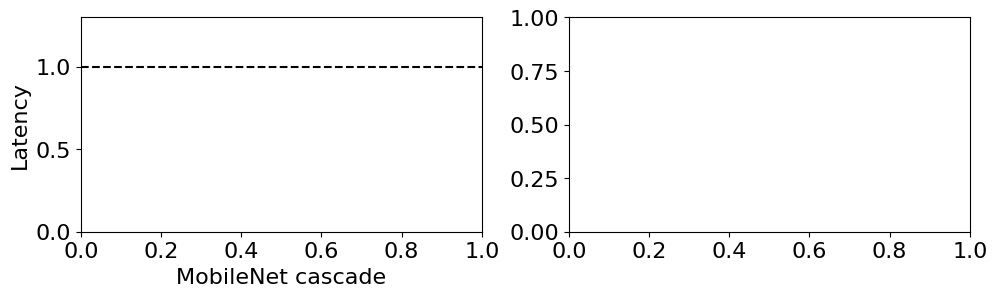

In [135]:
unfused_tensors = {
    "Early": {
        "Unfused": ["TA0", "TB0", "T1", "TA1", "TB1"],
        "TileFlow": ["T1"],
        "LoopTree": ["TB0", "T1", "TB1"],
        "LoopForest": ["TB0", "TB1"]
    },
    "Middle": {
        "Unfused": ["TA0", "TB0", "T1", "TA1", "TB1"],
        "TileFlow": ["T1"],
        "LoopTree": ["T1"],
        "LoopForest": []
    },
    "Late": {
        "Unfused": ["TA0", "TB0", "T1", "TA1", "TB1"],
        "TileFlow": ["T1"],
        "LoopTree": ["T1"],
        "LoopForest": []
    }
}

import matplotlib.pyplot as plt
import matplotlib
import numpy as np

font = {'family' : 'sans',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

GAP_BETWEEN_BAR = 0.2 # fraction of available space
GROUP_MARGIN = 0.15  # fraction of width_per_group

fig, axes = plt.subplots(1, 2, figsize=(10,3))

fig.tight_layout()

for i, (metric_name, data) in enumerate(zip(["Latency", "Energy"], [latencies, energies])):
    ax = axes[i]
    ax.set_ylabel(metric_name)
    ax.hlines(1.0, 0, 1, color='black', ls='--')
    ax.set_xlim((0, 1))
    ax.set_ylim((0, 1.3))
    ax.set_xlabel("MobileNet cascade")


    num_groups = len(data.keys())
    width_per_group = 1 / num_groups
    width_per_margin = GROUP_MARGIN*width_per_group
    usable_width_per_group = (1 - 2*GROUP_MARGIN)*width_per_group
    num_bars = len(next(iter(data.values())).keys())
    num_gaps = num_bars-1

    gap_space = GAP_BETWEEN_BAR*usable_width_per_group
    gap_width = gap_space/num_gaps

    bar_width = (usable_width_per_group-gap_space)/num_bars

    x_in_group_start = width_per_margin + 0.5*bar_width
    x_in_group_stride = bar_width + gap_width
    x_in_group = x_in_group_start + np.arange(num_bars)*x_in_group_stride

    ax.set_xticks(np.arange(num_groups)*width_per_group + 0.5*width_per_group, list(data.keys()))

    x_of_group = 0
    for cascade_name, cascade_data in data.items():
        print(cascade_name, cascade_data)

        datums = list(cascade_data.values())

        handles = ax.bar(x_of_group+x_in_group, datums, width=bar_width, color=['C0', 'C1', 'C2', 'C3'])

        x_of_group += width_per_group

    if i == 0:
        ax.legend(handles, ["LoopForest", "LoopTree", "TileFlow", "Unfused"], ncols=4, loc='upper center', bbox_to_anchor=(1.05, 1.4))

fig.savefig("mobilenet.pdf", dpi=400, bbox_inches='tight')

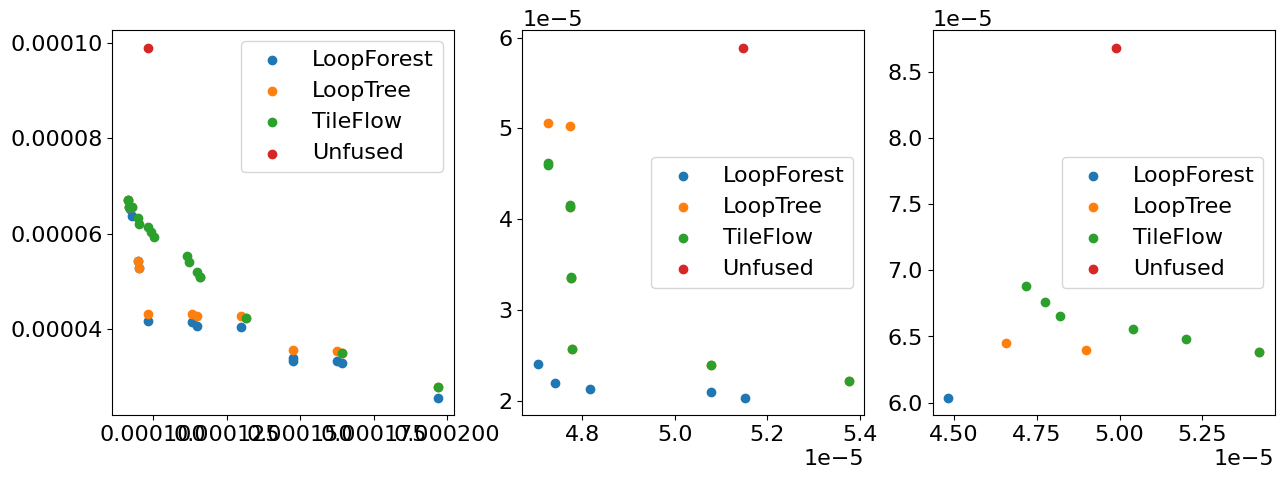

In [116]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

cascade_names = ["Early", "Middle", "Late"]
for i, (shape, cascade_name) in enumerate(zip([28, 14, 7], cascade_names)):
    ax = axes[i]
    latencies[cascade_name] = {}
    cascade_latencies = latencies[cascade_name]
    energies[cascade_name] = {}
    cascade_energies = energies[cascade_name]

    for name, short in zip(names, shorts):
        with open(f"{short}_{shape}.pkl", "rb") as f:
            df = pickle.load(f).data
        df.sort_values("Total<SEP>latency")
        ax.scatter(df["Total<SEP>latency"], df["Total<SEP>energy"], label=name, marker='o')
    ax.legend()

In [171]:
for cascade_name, shape in name_to_shape.items():
    print(cascade_name)
    df = pickle.load(open(f"lf_{shape}.pkl", "rb")).data
    edp = df["Total<SEP>energy"]*df["Total<SEP>latency"]
    argmin = edp.argmin()
    total_dram_energy = 0
    for k, v in df[[c for c in df.columns if 'energy' in c and 'MainMemory' in c]].iloc[argmin].items():
        total_dram_energy += v
    print('LoopForest', total_dram_energy/7.03e-12/1e6)
    total_glb_energy = 0
    for k, v in df[[c for c in df.columns if 'energy' in c and 'GlobalBuffer' in c]].iloc[argmin].items():
        total_glb_energy += v
    print('LoopForest', total_glb_energy/0.25e-12/1e6)

    df = pickle.load(open(f"lt_{shape}.pkl", "rb")).data
    edp = df["Total<SEP>energy"]*df["Total<SEP>latency"]
    argmin = edp.argmin()
    total_dram_energy = 0
    for k, v in df[[c for c in df.columns if 'energy' in c and 'MainMemory' in c]].iloc[argmin].items():
        total_dram_energy += v
    print('LoopTree', total_dram_energy/7.03e-12/1e6)
    total_glb_energy = 0
    for k, v in df[[c for c in df.columns if 'energy' in c and 'GlobalBuffer' in c]].iloc[argmin].items():
        total_glb_energy += v
    print('LoopTree', total_glb_energy/0.25e-12/1e6)

Early
LoopForest 3.022847999999999
LoopForest 75.5423232
LoopTree 3.2133119999999993
LoopTree 76.60793856000001
Middle
LoopForest 1.243136
LoopForest 43.336876032
LoopTree 1.2431359999999998
LoopTree 46.58266112
Late
LoopForest 6.4704
LoopForest 46.60559872
LoopTree 7.034880000000001
LoopTree 47.381068799999994


In [157]:
df = pickle.load(open(f"lt_{shape}.pkl", "rb")).data
edp = df["Total<SEP>energy"]*df["Total<SEP>latency"]
argmin = edp.argmin()
for k, v in df[[c for c in df.columns if 'energy' in c]].iloc[argmin].items():
    if v != 0:
        print(k, v)

Total<SEP>energy 6.453268607999999e-05
PwiseA0<SEP>energy<SEP>GlobalBuffer<SEP>read 7.744895999999999e-07
PwiseA0<SEP>energy<SEP>GlobalBuffer<SEP>write 5.0705408e-07
PwiseA0<SEP>energy<SEP>MainMemory<SEP>read 9.5203072e-06
PwiseA0<SEP>energy<SEP>MAC<SEP>compute 6.322176e-07
Dwise0<SEP>energy<SEP>GlobalBuffer<SEP>read 1.61017344e-06
Dwise0<SEP>energy<SEP>GlobalBuffer<SEP>write 1.0126079999999999e-06
Dwise0<SEP>energy<SEP>MainMemory<SEP>read 4.859136e-07
Dwise0<SEP>energy<SEP>MAC<SEP>compute 3.556224e-08
PwiseB0<SEP>energy<SEP>GlobalBuffer<SEP>read 8.8381056e-07
PwiseB0<SEP>energy<SEP>GlobalBuffer<SEP>write 4.886771199999999e-07
PwiseB0<SEP>energy<SEP>MainMemory<SEP>read 9.0793856e-06
PwiseB0<SEP>energy<SEP>MainMemory<SEP>write 8.818432e-07
PwiseB0<SEP>energy<SEP>MAC<SEP>compute 6.322176e-07
PwiseA1<SEP>energy<SEP>GlobalBuffer<SEP>read 7.744895999999999e-07
PwiseA1<SEP>energy<SEP>GlobalBuffer<SEP>write 5.6218496e-07
PwiseA1<SEP>energy<SEP>MainMemory<SEP>read 1.0843072e-05
PwiseA1<SEP>ene

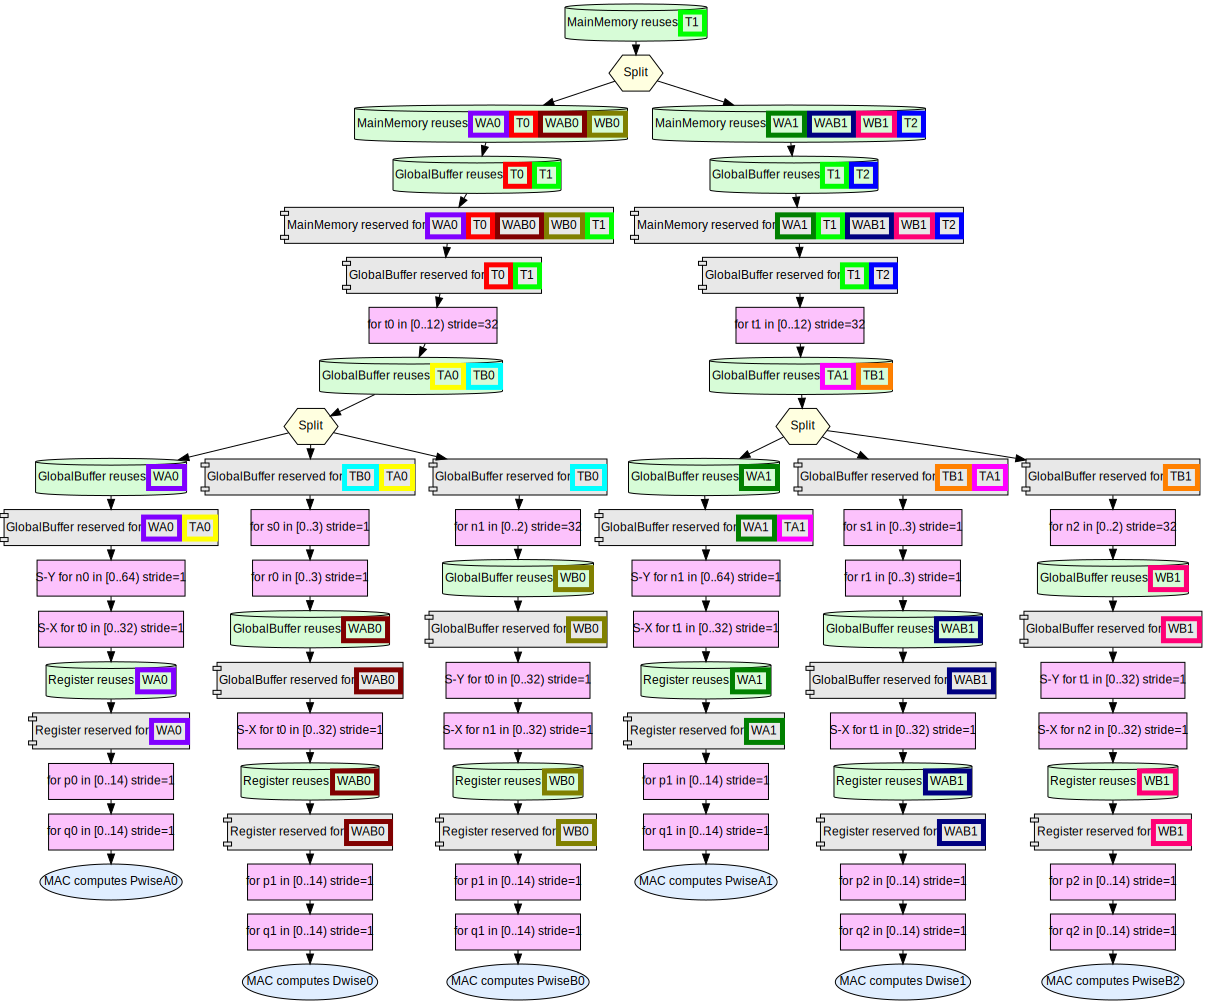

In [ ]:
shape = 14
df = pickle.load(open(f"lf_{shape}.pkl", "rb")).data
edp = df["Total<SEP>energy"]*df["Total<SEP>latency"]
argmin = edp.argmin()
display(SVG(df["Total<SEP>mapping"].iloc[argmin].render()))

In [ ]:
lf.data["Total<SEP>latency"]

In [ ]:
lt.data["Total<SEP>latency"]

In [ ]:
with open("fl_14", "wb") as f:
    pickle.dump(lf, f)

In [ ]:
display(SVG(lt.data["Total<SEP>mapping"].iloc[0].render()))